# Реккурентные сети. Word2Vec.

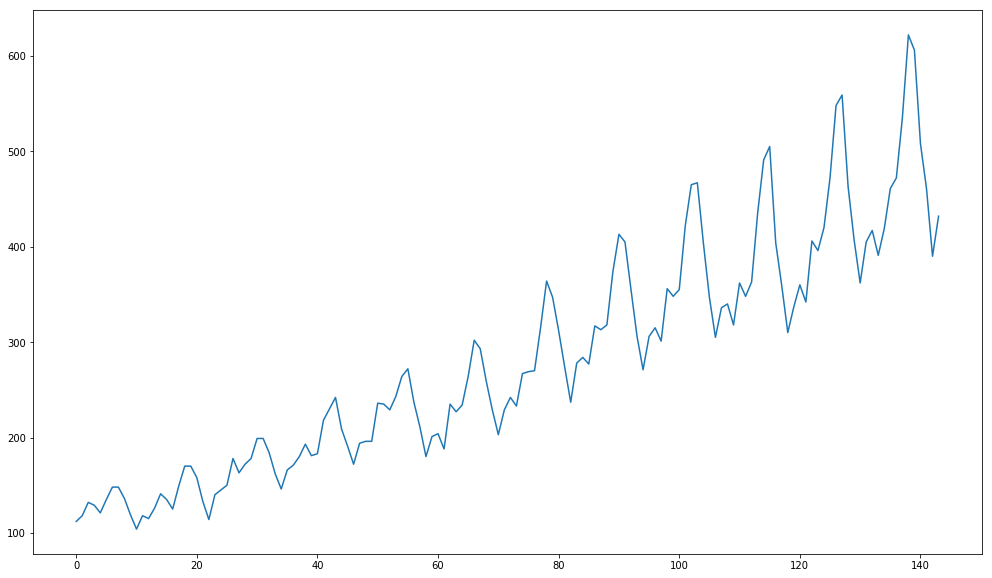

In [383]:
import pandas
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 17, 10

dataset = pandas.read_csv('https://github.com/lazyprogrammer/machine_learning_examples/raw/master/airline/international-airline-passengers.csv', 
                          usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()


In [384]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# зафиксируем random_state для дальнейшей воспроизводимости эксперимента
numpy.random.seed(7)

dataset = dataset.values # Keras умеет принимать на вход только numpy-матрицы
dataset = dataset.astype('float32')


# приведём все данные к интервалу значений от 0 до 1 (нормализуем)
# В принципе, если вы не используете регуляризацию, то можно не нормировать - результат будет тот же
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [385]:
# разобьём данные на трейн и тест. 
# В задачах предсказания временный рядов это нужно делать осторожно, чтобы случайно не перемешать порядок данных!
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


# сконвертируем данные таким образом, чтобы для каждого временного тика (начиная с look_back) были добавлены 
# признаки для look_back предыдущих состояний
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

96 48


In [386]:
# LSTM и RNN умеет работать с данными в таком формате [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 4, 1))
testX = numpy.reshape(testX, (testX.shape[0], 4, 1))

In [389]:
# А вот и вся наша нейросетка :)
model = Sequential()
model.add(LSTM(4, activation='sigmoid', batch_input_shape=(1, look_back, 1))) # 4 - размерность выхода, batch_input_shape = [batch_size, time steps, features]
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, validation_data=(testX, testY))

ValueError: Error when checking target: expected dense_13 to have shape (None, 1) but got array with shape (1, 91)

In [388]:
# получим предсказания
trainPredict = model.predict(trainX, batch_size=1)
testPredict = model.predict(testX, batch_size=1)
# преобразуем обратно наши данные из интервала (0, 1) в исходных диапазон значений
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# посчитаем MSE для наших предсказаний
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 36.16 RMSE
Test Score: 99.41 RMSE


# Православный LSTM на PyTorch

In [510]:
from torch.autograd import Variable
import torch.nn as nn
import torch

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm = nn.LSTMCell(1, 4)
        self.linear = nn.Linear(4, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = Variable(torch.zeros(1, 4), requires_grad=False)
        c_t = Variable(torch.zeros(1, 4), requires_grad=False)

        for i, input_t in enumerate(input):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
            
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
            
        outputs = torch.stack(outputs, 1).squeeze().unsqueeze(-1)
        
        return outputs

In [511]:
model = Sequence()

In [512]:
x_train = Variable(torch.FloatTensor(train))
x_test = Variable(torch.FloatTensor(test))

In [514]:
import numpy as np

opt = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch_i in range(100):           
    # train
    opt.zero_grad()
    for j in np.random.permutation(x_train.size()[0] - 5):
        delta = 4
        
        cur_interval = x_train[j:j + delta]
        next_value = x_train[j + delta]
        
        cur_preds = model(cur_interval)
        
        cur_loss = torch.nn.MSELoss()(cur_preds[:-1], cur_interval[1:])
        cur_loss.backward()
        opt.step()
    
    # final loss on train 
    loss = Variable(torch.zeros([1]))
    for j in range(x_train.size()[0] - 5):
        delta = 4
        
        cur_interval = x_train[j:j + delta]
        next_value = x_train[j + delta]
        
        cur_preds = model(cur_interval)
        
        loss += torch.nn.MSELoss()(cur_preds[-1], next_value) 
        
    print("Iteration ", epoch_i)
    print("Loss on train", loss.data[0] / (x_train.size()[0] - 5))
    
    
    #final loss on test
    loss = Variable(torch.zeros([1]))
    for j in range(x_test.size()[0] - 6):
        delta = 4
        
        cur_interval = x_test[j:j + delta]
        next_value = x_test[j + delta]
        
        predictions = model(cur_interval)
        
        loss += torch.nn.MSELoss()(predictions[-1], next_value)
        
    print("Loss on test", loss.data[0] /  (x_test.size()[0] - 5))

Iteration  0
Loss on train 0.012987744677197802
Loss on test 0.08693876377371855
Iteration  1
Loss on train 0.020205746640215863
Loss on test 0.05345758171968682
Iteration  2
Loss on train 0.01516015975029914
Loss on test 0.061400607574817745
Iteration  3
Loss on train 0.016851186752319336
Loss on test 0.045726820479991825
Iteration  4
Loss on train 0.009302563064700954
Loss on test 0.07241369402685831
Iteration  5
Loss on train 0.021680048533848355
Loss on test 0.019036225108213203
Iteration  6
Loss on train 0.009127587407499879
Loss on test 0.0855274754901265
Iteration  7
Loss on train 0.0328939642224993
Loss on test 0.012732548769130263
Iteration  8
Loss on train 0.02073718296302544
Loss on test 0.14003525223842886
Iteration  9
Loss on train 0.024970434524200776
Loss on test 0.016513008017872654
Iteration  10
Loss on train 0.012192065899188701
Loss on test 0.10596118971358898
Iteration  11
Loss on train 0.013022742428622404
Loss on test 0.019601390805355338
Iteration  12
Loss on tra

In [515]:
train_predictions = []
    
for j in range(x_train.size()[0] - 5):
    delta = 4
        
    cur_interval = x_train[j:j + delta]
    next_value = x_train[j + delta]
        
    cur_preds = model(cur_interval)
        
    train_predictions.append(cur_preds.data.tolist()[-1])

In [516]:
test_predictions = []
    
for j in range(x_test.size()[0] - 5):
    delta = 4
        
    cur_interval = x_test[j:j + delta]
    next_value = x_test[j + delta]
        
    cur_preds = model(cur_interval)
        
    test_predictions.append(cur_preds.data.tolist()[-1])

In [517]:
train_predictions = np.array(train_predictions)
test_predictions = np.array(test_predictions)

In [494]:
# преобразуем обратно наши данные из интервала (0, 1) в исходных диапазон значений
trainPredict = scaler.inverse_transform(train_predictions)
#trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(test_predictions)
#testY = scaler.inverse_transform([testY])
# посчитаем MSE для наших предсказаний
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 34.94 RMSE
Test Score: 83.48 RMSE


In [518]:
# преобразуем обратно наши данные из интервала (0, 1) в исходных диапазон значений
trainPredict = scaler.inverse_transform(train_predictions)
#trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(test_predictions)
#testY = scaler.inverse_transform([testY])
# посчитаем MSE для наших предсказаний
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 39.66 RMSE
Test Score: 43.11 RMSE


# LSTM на тексте

In [5]:
from keras.datasets import imdb
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Загрузим датасет

In [2]:
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words)

/Users/binom/.anaconda3/lib/python3.5/site-packages/keras/datasets/imdb.py:45: UserWarning: The `nb_words` argument in `load_data` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `load_data` '


Необходимо привести все к однообразной форме

In [3]:
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [11]:
X_train

array([[   0,    0,    0, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ..., 
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)

In [14]:
# Создаем модель
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


# Задачка

In [15]:
import pandas as pd
data = pd.read_csv("train-contest.csv")

In [16]:
data["BodyMarkdown"][0]

'In My VB.NET web page, I have this standard event. Note the "Handles" clause on teh event declaration.\r\n\r\n    Protected Sub Page_Load(ByVal sender As Object, ByVal e As System.EventArgs) Handles Me.Load\r\n    End Sub\r\n\r\nIn my C# web app, I have this:\r\n\r\n    protected void Page_Load(object sender, System.EventArgs e)\r\n    {\r\n\r\nSince C# doesn\'t have a "Handles" equivalent and from what I\'ve seen, event handlers are wired up using delegate += syntax, I was looking for this, but I could not foind it in the aspx page, aspx.cs file or the aspx.designer.cs file.\r\n\r\nIn VB, I would have two drop down lists at the top of  the Code Editor window and I could select any object on the web form or the web form itself and see the possible events for the object. Selecting the event would either take me to the event handler or if it didn\'t exists, it would create the stub for me.\r\n\r\nI know that the Properties window in C# (and I think in VB, too) has an Event tab that show

In [17]:
data.shape

(100000, 15)